# TOPIC Modelling
Ce notebook est très fortement inspiré de cet exemple: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [1]:
import pandas as pd
import numpy as np
import spacy

## Import des données
Les données suivantes sont des tweets dont l'utilisateur est "diagnostiqué anxieux ou pas.

In [2]:
df = pd.read_pickle("test_anx_2019.pkl", compression="zip")
df.head()

,subject,text,at_risk
0,subject1001,First Submission. Strikeforce: Rockhold vs J...,0
1,subject1001,"Gainesville, FL \t Need an atheist haven in G...",0
2,subject1001,Bill Maher discusses Atheism not being a reli...,0
3,subject1001,UG member relates horrors of unregulated MMA ...,0
4,subject1001,\t Judging by the look he gave her when he ...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570509 entries, 0 to 570508
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   subject  570509 non-null  object
 1   text     570509 non-null  object
 2   at_risk  570509 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 13.1+ MB


In [4]:
print("Nombre de sujets étudiés: %d" % df.subject.nunique())
print("Nombre de sujets à risque: %d" % df[df.at_risk == 1].subject.nunique())
print("Pourcentage de tweets de sujets à risque: %.2f" % ((df.at_risk.value_counts()[1]*100)/len(df)))

Nombre de sujets étudiés: 815
Nombre de sujets à risque: 73
Pourcentage de tweets de sujets à risque: 3.09


In [5]:
df2 = pd.read_pickle("train_anx_2019.csv", compression="zip")
df2.head()

,subject,text,at_risk
0,subject1001,First Submission. Strikeforce: Rockhold vs J...,0
1,subject1001,"Gainesville, FL \t Need an atheist haven in G...",0
2,subject1001,Bill Maher discusses Atheism not being a reli...,0
3,subject1001,UG member relates horrors of unregulated MMA ...,0
4,subject1001,\t Judging by the look he gave her when he ...,0


In [6]:
# work on sample

## Nettoyage avec Spacy
-  Lemmatisation
-  Stopwords

In [7]:
import os

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pyLDAvis

import spacy
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")




In [8]:
# Récupère les tweets des sujets à risque
s = df[df.at_risk == 1].sample(500)
s2 = df[df.at_risk == 0].sample(500)

s = s.append(s2)
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

docs = (nlp(tweet) for tweet in s.text)
corpus = []
for tweet in lemmatizer.pipe(docs, batch_size=50):
    corpus.append(" ".join([w.lemma_ for w in tweet if w.lemma_ not in spacy_stopwords]))

In [9]:
corpus

["   \t  unfortunately , body picky med work I med option sight . // : honestly , I glad I find med work I body adjust I restrict / fasting . y'know ?",
 '  slightly overboard amiibo purchase \t  ',
 '   \t  ugh , congrat lovely ! amazing , holy shit leg look fiiiiine',
 '   \t  play bottle noise alert teacher , I feel bro .',
 '  help \t   event significant ? I think , I think happen screw deep level , I nt know . I m confused , I feel like I nt remember big thing happen couple month I .   detail I remember think   1 . shortly rape I , start talk guy , start distant 2 . week distance , suddenly start talk want buy I super expensive Christmas ( upwards $ 200 , s like 17 ) 3 . angry , super remove 4 . look I eye sexual situation 5 . tell I want I throw bed rough sex .   switch angry want hurt I affectionate blame sympathy I I think deep , manipulate I threaten I I think calculate I think . I nt know I drug ... I nt think I , time pick I half drunken smoothie I drink taste weird I goofy 

In [45]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Les mots qui apparaissent moins de 3 fois sont supprimés, 
vectorizer = CountVectorizer(
                            stop_words = 'english',
                            min_df=10,
                            max_features=10000,
                            )

doc_term_matrix = vectorizer.fit_transform(corpus)

## Check the Sparcity

In [46]:
# Materialize the sparse data
data_dense = doc_term_matrix.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.1184426229508198 %




### LDA
le nombre de component au départ est prit au hasard car nous ne disposons pas de connaissances 
préalables sur les troubbles anxieux.

In [47]:
lda_model = LatentDirichletAllocation(n_components=10,
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=666,
                                     evaluate_every = -1,
                                     n_jobs=-1,
                                     )
lda_output = lda_model.fit_transform(doc_term_matrix)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=666)


### Diagnostique du modèle

In [48]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(doc_term_matrix))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(doc_term_matrix))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -37513.33217039148
Perplexity:  247.9986507103526
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 666, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Recherche des meilleurs paramètres

In [49]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [3, 5, 7, 9], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_term_matrix)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 5, 7, 9]})

In [50]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -8233.485219474234
Model Perplexity:  209.18827418476738


In [54]:
result_df = pd.DataFrame(model.cv_results_)

log_likelyhoods_5 = result_df[result_df["param_learning_decay"]==0.5]["mean_test_score"]
log_likelyhoods_7 = result_df[result_df["param_learning_decay"]==0.7]["mean_test_score"]
log_likelyhoods_9 =  result_df[result_df["param_learning_decay"]==0.9]["mean_test_score"]

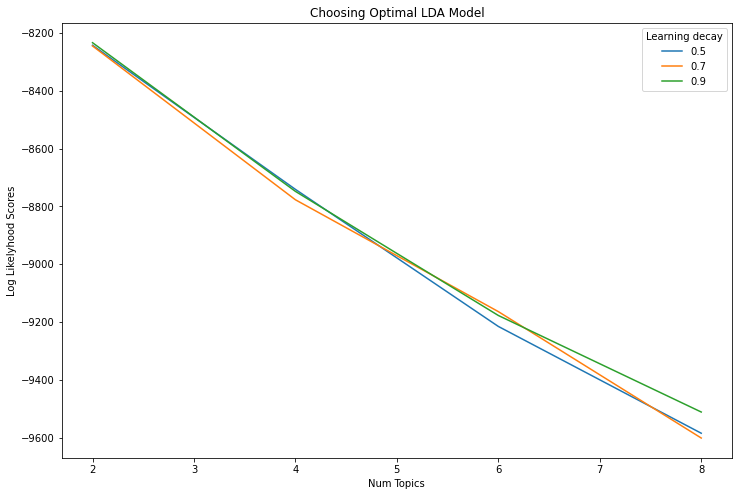

In [55]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [2, 4, 6, 8]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Classifier un document selon son topic
### Vérifier le topic dominant de chaque document en regardant lequel à la plus haute contribution pour chaqun des documents

In [53]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_term_matrix)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.050000,0.900000,0.050000,1
Doc1,0.330000,0.330000,0.330000,0
Doc2,0.140000,0.120000,0.740000,2
Doc3,0.110000,0.120000,0.770000,2
Doc4,0.010000,0.980000,0.010000,1
Doc5,0.030000,0.030000,0.940000,2
Doc6,0.330000,0.330000,0.330000,0
Doc7,0.060000,0.060000,0.880000,2
Doc8,0.530000,0.410000,0.060000,0
Doc9,0.650000,0.180000,0.170000,0


#### Distribution des topics

In [56]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,415
1,1,323
2,2,262


## Visualisations

In [57]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_term_matrix, vectorizer, mds='pcoA')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.021638 -0.155353       1        1  37.599632
0     -0.161369  0.060930       2        1  36.346876
2      0.139731  0.094423       3        1  26.053493, topic_info=       Term        Freq       Total Category  logprob  loglift
80     good  113.000000  113.000000  Default  30.0000  30.0000
158  people  154.000000  154.000000  Default  29.0000  29.0000
98    https   67.000000   67.000000  Default  28.0000  28.0000
206   thank   48.000000   48.000000  Default  27.0000  27.0000
32      com   66.000000   66.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
132   maybe   15.966976   32.635696   Topic3  -4.7097   0.6301
127     lot   20.622439   77.280810   Topic3  -4.4539   0.0240
143    need   16.984930   52.847623   Topic3  -4.6479   0.2099
17      bit   14.962153   37.699291   Topic3  -4.7747   0.4209
222    want   14.808385  106.231669   Topic3  -4.7851  -0.6254

[177 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.083797        10
0         3  0.879870        10
3         1  0.320129  actually
3         2  0.626340  actually
3         3  0.055675  actually
...     ...       ...       ...
241       3  0.639941      year
242       1  0.049817       yes
242       2  0.099633       yes
242       3  0.846882       yes
243       2  0.973357   youtube

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### Retrouver les mots clés des topics

In [58]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,10,100,able,actually,add,ago,agree,amazing,anymore,ask,...,word,work,world,write,wrong,www,yeah,year,yes,youtube
Topic0,0.462486,0.334347,1.351864,45.973501,0.344413,0.702579,12.339383,0.346999,0.356918,1.649093,...,8.370437,14.848177,10.231510,0.880624,16.571548,51.279105,0.352793,8.567312,1.912318,19.306469
Topic1,2.197585,5.038853,19.899262,23.461147,0.337822,11.150043,7.305078,5.404339,9.805445,23.777510,...,2.081661,49.263403,0.383235,0.341620,5.882861,0.337099,4.481827,18.391507,0.783807,0.340108
Topic2,22.339929,6.626801,7.748874,4.565352,22.317765,5.147378,0.355538,9.248662,5.837638,0.573397,...,5.547902,4.888421,10.385255,14.777756,3.545591,0.383796,16.165380,48.041181,18.303874,0.353422


In [60]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,people,https,com,like,www,actually,way,movie,come,look,book,want,lot,thing,know,http,involve,kind,right,en
Topic 1,think,like,feel,want,time,day,know,help,nt,work,eat,people,try,start,thing,weight,food,use,need,tell
Topic 2,good,like,feel,thank,year,know,game,think,love,sound,thing,remove,come,new,use,10,add,god,lot,point


# Prédire le topic pour un nouveau Tweet

In [23]:
# # Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["Some text about christianity and bible"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

Component's weights: 
 [[ 0.49  0.67  0.56]
 [-0.3   0.74 -0.61]]
Perc of Variance Explained: 
 [0.01 0.57]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

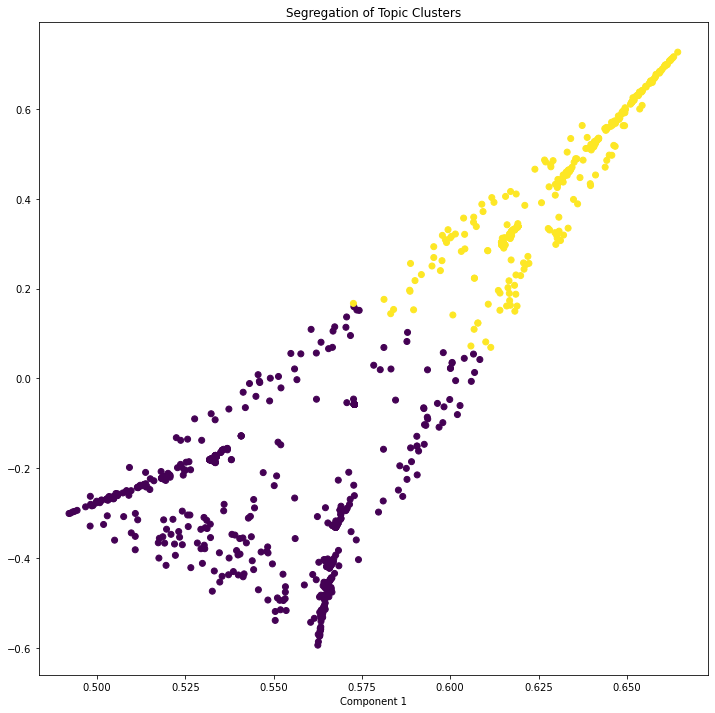

In [62]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clusters = KMeans(n_clusters=2, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [43]:
lda_model = LatentDirichletAllocation(n_components=10, random_state=888)
lda_model.fit(doc_term_matrix)
data = pyLDAvis.sklearn.prepare(lda_model, doc_term_matrix, vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(data)

In [63]:
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure 

print(len(s.at_risk),(df_document_topic.dominant_topic == 0).sum())
print(adjusted_rand_score(s.at_risk, df_document_topic.dominant_topic))
print(homogeneity_completeness_v_measure(s.at_risk, df_document_topic.dominant_topic))

1000 415
0.021833707217524465
(0.023211681403546642, 0.01488448440747955, 0.018137988564847992)


In [64]:
print(adjusted_rand_score(s.at_risk, clusters))
print(homogeneity_completeness_v_measure(s.at_risk, clusters))

0.01875663753668492
(0.01657227043428461, 0.018506812715573626, 0.017486198478387695)
